Epoch 1/10
18/18 [==============================] - 18s 921ms/step - loss: 1.1108 - accuracy: 0.4786 - val_loss: 0.6209 - val_accuracy: 0.7667
Epoch 2/10
18/18 [==============================] - 17s 903ms/step - loss: 0.6030 - accuracy: 0.7429 - val_loss: 0.5008 - val_accuracy: 0.7500
Epoch 3/10
18/18 [==============================] - 16s 874ms/step - loss: 0.4938 - accuracy: 0.8143 - val_loss: 0.4502 - val_accuracy: 0.7500
Epoch 4/10
18/18 [==============================] - 16s 877ms/step - loss: 0.4135 - accuracy: 0.8429 - val_loss: 0.2619 - val_accuracy: 0.9167
Epoch 5/10
18/18 [==============================] - 16s 874ms/step - loss: 0.4073 - accuracy: 0.8536 - val_loss: 0.3747 - val_accuracy: 0.9167
Epoch 6/10
18/18 [==============================] - 16s 912ms/step - loss: 0.3834 - accuracy: 0.8429 - val_loss: 0.2093 - val_accuracy: 0.9000
Epoch 7/10
18/18 [==============================] - 16s 901ms/step - loss: 0.2993 - accuracy: 0.8821 - val_loss: 0.1958 - val_accuracy: 0.9500

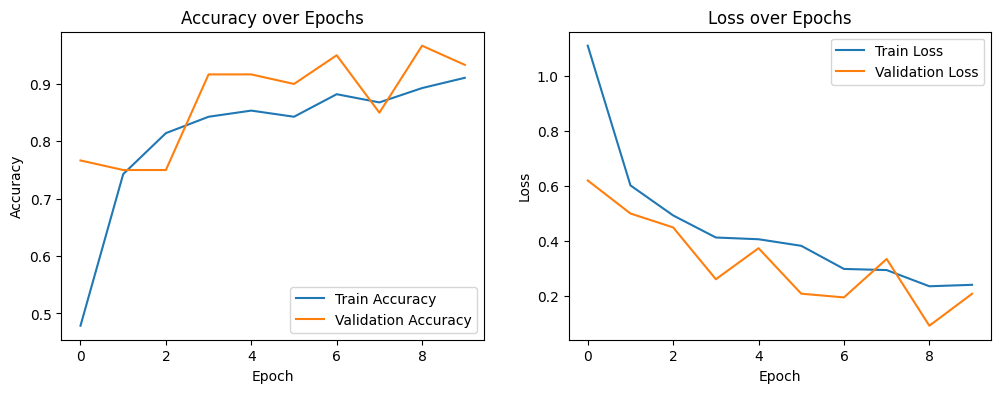

2/2 [==============================] - 1s 433ms/step - loss: 0.0877 - accuracy: 0.9500
Test accuracy: 0.9500
2/2 [==============================] - 1s 431ms/step


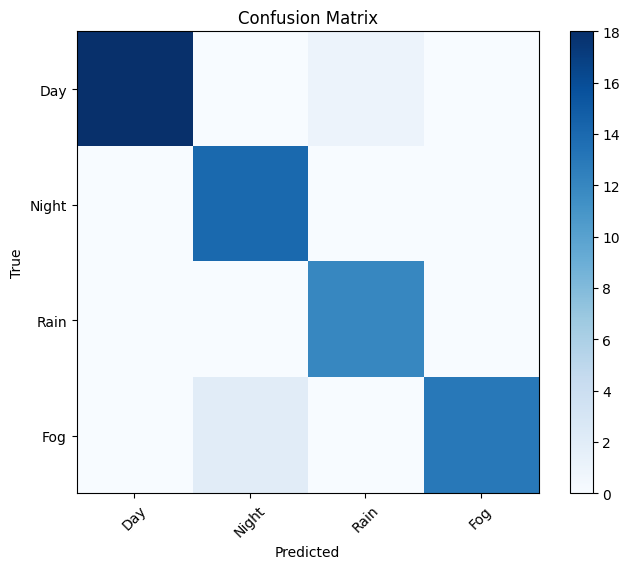

c:\Users\koohi\anaconda3\envs\CARLA\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Prepare dataset for training
def prepare_dataset(dataset_dir='dataset'):
    images = []
    labels = []
    label_map = {'day': 0, 'night': 1, 'rain': 2, 'fog': 3}
    
    for condition in label_map.keys():
        condition_dir = os.path.join(dataset_dir, condition)
        for img_name in os.listdir(condition_dir):
            img_path = os.path.join(condition_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:  # Check if the image is loaded correctly
                continue
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(label_map[condition])
    
    images = np.array(images) / 255.0  # Normalize images
    labels = tf.keras.utils.to_categorical(labels, num_classes=4)
    
    # Split data into Train and Temp (which will later be split into Validation and Test)
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, 
                                                        test_size=0.3, 
                                                        random_state=42)
    
    # Split Temp into Validation and Test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                                    test_size=0.5, 
                                                    random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Build and train CNN model
def build_and_train_model(X_train, y_train, X_val, y_val):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),  # Add Dropout to prevent Overfitting
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),  # Another Dropout before the final layer
        layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    # Data Augmentation for Train
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2
    )
    
    # Early Stopping to prevent Overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model with Data Augmentation
    history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                        epochs=10,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    
    return model, history

# Plot learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Evaluate model and plot confusion matrix
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = ['Day', 'Night', 'Rain', 'Fog']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Main execution for training
def main():
    # Prepare the data
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset()
    
    # Train the model
    model, history = build_and_train_model(X_train, y_train, X_val, y_val)
    
    # Plot learning curves
    plot_learning_curves(history)
    
    # Evaluate the model on Test data
    evaluate_model(model, X_test, y_test)
    
    # Save the model
    model.save('weather_classifier_model.h5')

if __name__ == '__main__':
    main()